In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
from sklearn.model_selection import train_test_split

c:\Users\abdel\.conda\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\abdel\.conda\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\abdel\.conda\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Define data path
train_data_dir = "Images/SEMI-BALANCED/Train"
validation_data_dir = "Images/SEMI-BALANCED/Valid"
test_data_dir = "Images/SEMI-BALANCED/Test"


# Define hyperparameters
IMAGE_SIZE = 160
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
NUM_CLASSES = 5
# Load MobileNet V2 pre-trained model
mobilenet_v2 = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                                 include_top=False,
                                                 weights='imagenet')


# Load data and split into training and validation sets
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(validation_data_dir,
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=16,
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                batch_size=16,
                                                shuffle=False,
                                                class_mode='categorical')

Found 37680 images belonging to 5 classes.
Found 13068 images belonging to 5 classes.
Found 6540 images belonging to 5 classes.


In [3]:
# Add a global average pooling layer and a dense output layer
#Model 1
# for layer in mobilenet_v2.layers[:-4]:
#     layer.trainable = False
    
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(mobilenet_v2.output)
# flatten = tf.keras.layers.Flatten()(global_average_layer)
# dense1 = tf.keras.layers.Dense(512, 'relu')(flatten)
# dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
# dense2 = tf.keras.layers.Dense(256, 'relu')(dropout1)
# dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
# output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dropout2)
# ----------------------------------------
#Model 2
for layer in mobilenet_v2.layers[:-5]:
    layer.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(mobilenet_v2.output)
output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(global_average_layer)
model = tf.keras.models.Model(inputs=mobilenet_v2.input, outputs=output_layer)
# ----------------------------------------
#Model 3
# base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
#                          include_top=False,
#                          weights='imagenet')

# # freeze the base model layers
# base_model.trainable = False

# # add the classification head
# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(5, activation='softmax')
# ])
# Define the model

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\abdel\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [4]:
# x_train, x_val, y_train, y_val = train_test_split(data[0][0], data[0][1], test_size=0.2, random_state=42)
# print(x_train.shape, x_val.shape)
# train_generator = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_generator = train_generator.shuffle(buffer_size=1024).batch(BATCH_SIZE)

# val_generator = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_generator = val_generator.batch(BATCH_SIZE)

# Train the model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

class EvaluateEpochEnd(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        
        scores = self.model.evaluate(self.test_data, verbose=False)
        print('\nTesting loss: {}, accuracy: {}\n'.format(scores[0], scores[1]))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

callbacks=[reduce_lr, early_stop, EvaluateEpochEnd(test_generator)]
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=callbacks)

Epoch 1/10
1178/1178 [==============================] - 1984s 2s/step - loss: 1.0028 - accuracy: 0.6037 - val_loss: 16.2366 - val_accuracy: 0.1844

Testing loss: 15.910932540893555, accuracy: 0.1839449554681778

Epoch 2/10
1178/1178 [==============================] - 64s 54ms/step - loss: 0.8261 - accuracy: 0.6783 - val_loss: 4.6677 - val_accuracy: 0.3013

Testing loss: 4.13379430770874, accuracy: 0.3255351781845093

Epoch 3/10
1178/1178 [==============================] - 64s 55ms/step - loss: 0.7489 - accuracy: 0.7094 - val_loss: 9.4131 - val_accuracy: 0.1928

Testing loss: 8.879566192626953, accuracy: 0.1948012262582779

Epoch 4/10
1178/1178 [==============================] - 64s 55ms/step - loss: 0.6930 - accuracy: 0.7306 - val_loss: 2.6685 - val_accuracy: 0.5370

Testing loss: 2.3172178268432617, accuracy: 0.5850152969360352

Epoch 5/10
1178/1178 [==============================] - 64s 54ms/step - loss: 0.6569 - accuracy: 0.7437 - val_loss: 1.1935 - val_accuracy: 0.6631

Testing los

In [5]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

409/409 [==============================] - 9s 23ms/step - loss: 0.5186 - accuracy: 0.8199
Test loss: 0.5186330676078796
Test accuracy: 0.8198776841163635


accuracy score 0.8198776758409786
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       838
           1       0.59      0.95      0.73      1203
           2       0.92      0.75      0.83      2039
           3       0.95      0.83      0.89      1480
           4       0.89      0.80      0.84       980

    accuracy                           0.82      6540
   macro avg       0.85      0.83      0.82      6540
weighted avg       0.86      0.82      0.83      6540



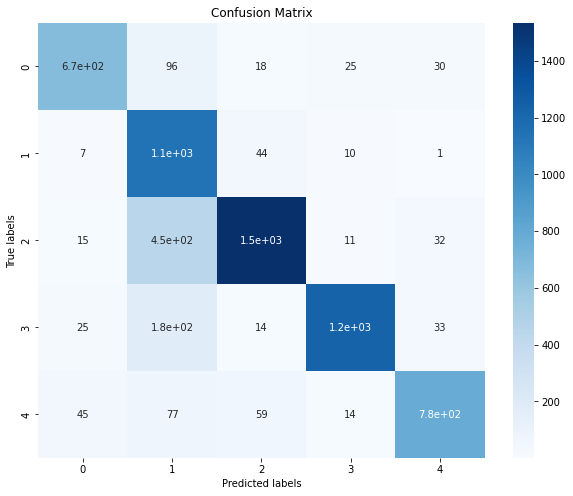

In [6]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_names = [0, 1, 2, 3, 4]
print('accuracy score', accuracy_score(y_true, y_pred))
confusion_mtx = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
cr = classification_report(y_true, y_pred)
print(cr)
sns.heatmap(confusion_mtx, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [7]:
print(confusion_mtx)

[[ 669   96   18   25   30]
 [   7 1141   44   10    1]
 [  15  447 1534   11   32]
 [  25  175   14 1233   33]
 [  45   77   59   14  785]]
